# CIFAR10 with DenseNet and TPU_20181201

## 1. Obtain CIFAR10 dataset

In [0]:
import tensorflow as tf
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline
import importlib

tf.__version__

'1.12.0'

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 12s 0us/step


Here's an example of CIFAR-10

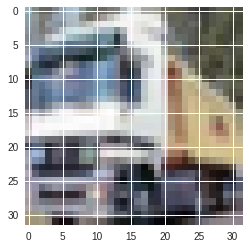

In [0]:
plt.imshow(x_train[1])

We want to normalize pixel values (0-255) to unit interval.

In [0]:
x_train = x_train/255.
x_test = x_test/255.

In [0]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [0]:
# Make categorical
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

print(np.shape(y_train))
print(np.shape(y_test ))

(50000, 10)
(10000, 10)


## 2. Build our DenseNet model

In [0]:
BATCH_SIZE = 1024
NUM_CLASSES = 10
EPOCHS = 300

# input image dimensions
IMG_ROWS, IMG_COLS = 32, 32


In [0]:
def convolution_block(x, nb_channels, dropout_rate=None, bottleneck=False, weight_decay=1e-4):
    """
    Creates a convolution block consisting of BN-ReLU-Conv.
    Optional: bottleneck, dropout
    """
    
    # Bottleneck
    if bottleneck:
        bottleneckWidth = 4
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Convolution2D(nb_channels * bottleneckWidth, (1, 1), use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
        # Dropout
        if dropout_rate:
            x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    # Standard (BN-ReLU-Conv)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Convolution2D(nb_channels, (3, 3), padding='same', use_bias=False)(x)
    
    # Dropout
    if dropout_rate:
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    return x


In [0]:
def dense_block(x, nb_layers, nb_channels, growth_rate, dropout_rate=None, bottleneck=False, weight_decay=1e-4):
    """
    Creates a dense block and concatenates inputs
    """
    
    x_list = [x]
    for i in range(nb_layers):
        cb = convolution_block(x, growth_rate, dropout_rate, bottleneck)
        x_list.append(cb)
        x = tf.keras.layers.Concatenate(axis=-1)(x_list)
        nb_channels += growth_rate
    return x, nb_channels


In [0]:
def transition_layer(x, nb_channels, dropout_rate=None, compression=1.0, weight_decay=1e-4):
    """
    Creates a transition layer between dense blocks as transition, which do convolution and pooling.
    Works as downsampling.
    """
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Convolution2D(int(nb_channels*compression), (1, 1), padding='same',
                      use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
    
    # Adding dropout
    if dropout_rate:
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    x = tf.keras.layers.AveragePooling2D((2, 2), strides=(2, 2))(x)
    return x

In [0]:
def DenseNet(
    __version__ = '0.1',
    input_shape = (32,32,3),
    dense_blocks=3,
    dense_layers=-1,
    growth_rate=12,
    nb_classes=None,
    dropout_rate=None,
    bottleneck=False,
    compression=1.0,
    weight_decay=1e-4,
    depth=40):
    """
    Creating a DenseNet
    
    Arguments:
        input_shape  : shape of the input images. E.g. (28,28,1) for MNIST    
        dense_blocks : amount of dense blocks that will be created (default: 3)    
        dense_layers : number of layers in each dense block. You can also use a list for numbers of layers [2,4,3]
                       or define only 2 to add 2 layers at all dense blocks. -1 means that dense_layers will be calculated
                       by the given depth (default: -1)
        growth_rate  : number of filters to add per dense block (default: 12)
        nb_classes   : number of classes
        dropout_rate : defines the dropout rate that is accomplished after each conv layer (except the first one).
                       In the paper the authors recommend a dropout of 0.2 (default: None)
        bottleneck   : (True / False) if true it will be added in convolution block (default: False)
        compression  : reduce the number of feature-maps at transition layer. In the paper the authors recomment a compression
                       of 0.5 (default: 1.0 - will have no compression effect)
        weight_decay : weight decay of L2 regularization on weights (default: 1e-4)
        depth        : number or layers (default: 40)
        
    Returns:
        Model        : A Keras model instance
    """
    
    if nb_classes==None:
        raise Exception('Please define number of classes (e.g. num_classes=10). This is required for final softmax.')
    
    if compression <=0.0 or compression > 1.0:
        raise Exception('Compression have to be a value between 0.0 and 1.0.')
    
    if type(dense_layers) is list:
        if len(dense_layers) != dense_blocks:
            raise AssertionError('Number of dense blocks have to be same length to specified layers')
    elif dense_layers == -1:
        dense_layers = int((depth - 4)/3)
        if bottleneck:
            dense_layers = int(dense_layers / 2)
        dense_layers = [dense_layers for _ in range(dense_blocks)]
    else:
        dense_layers = [dense_layers for _ in range(dense_blocks)]
        
    img_input = tf.keras.layers.Input(shape=input_shape)
    nb_channels = growth_rate
    
    print('Creating DenseNet %s' % __version__)
    print('#############################################')
    print('Dense blocks: %s' % dense_blocks)
    print('Layers per dense block: %s' % dense_layers)
    print('#############################################')
    
    # Initial convolution layer
    x = tf.keras.layers.Convolution2D(2 * growth_rate, (3,3), padding='same',strides=(1,1),
                      use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(img_input)
    
    # Building dense blocks
    for block in range(dense_blocks - 1):
        
        # Add dense block
        x, nb_channels = dense_block(x, dense_layers[block], nb_channels, growth_rate, dropout_rate, bottleneck, weight_decay)
        
        # Add transition_block
        x = transition_layer(x, nb_channels, dropout_rate, compression, weight_decay)
        nb_channels = int(nb_channels * compression)
    
    # Add last dense block without transition but for that with global average pooling
    x, nb_channels = dense_block(x, dense_layers[-1], nb_channels, growth_rate, dropout_rate, weight_decay)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    x = tf.keras.layers.Dense(nb_classes, activation='softmax')(x)
    
    return tf.keras.Model(img_input, x, name='densenet')
    

In [0]:
model = DenseNet(input_shape=(32,32,3), nb_classes=10, depth=40, growth_rate=12,
                          dropout_rate=0.2, bottleneck=False, compression=1)

Creating DenseNet 0.1
#############################################
Dense blocks: 3
Layers per dense block: [12, 12, 12]
#############################################


In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 24)   648         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 24)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 24)   0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

## 3. Training the DenseNet model on TPU

In [0]:
strategy = tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
model = tf.contrib.tpu.keras_to_tpu_model(model, strategy=strategy)

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.47.1.10:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 1841963482927676573)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 4301929721349547752)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 14628622697318541525)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 16953963249297322043)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 6192663557221607944)
INFO:tensorflow:*** Available Device: _DeviceAt

In [0]:
model.compile(
      loss=tf.keras.losses.categorical_crossentropy,
      optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.05),
      metrics=['accuracy'])

In [16]:
%time history=model.fit( x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Loss for final step:', score[0])
print('Accuracy ', score[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/300
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(128, 32, 32, 3), dtype=tf.float32, name='input_1_10'), TensorSpec(shape=(128, 10), dtype=tf.float32, name='dense_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 34.12232279777527 secs
INFO:tensorflow:Setting weights on TPU model.
48128/50000 [===========================>..] - ETA: 3s - loss: 2.1534 - acc: 0.2773INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(106,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(106, 32, 32, 3), dtype=tf.float32, name='input_1_10'), TensorSpec(shape=(106, 10), dtype=tf.float32, name='dense_target_10')]
INFO:tensorflow:Overriding default placeho

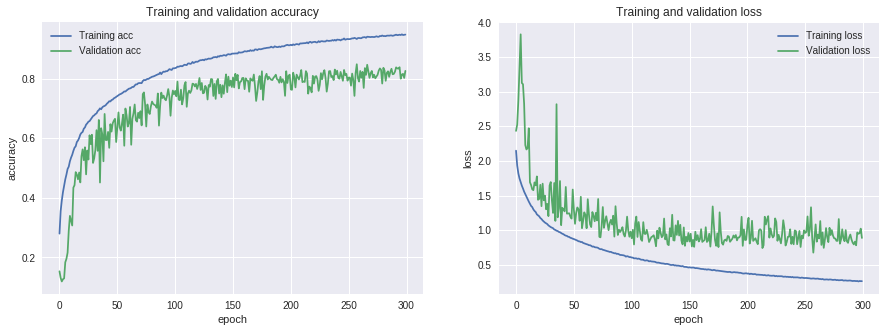

In [17]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
            
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.show()

## 4. Obtain predictions (inference)

INFO:tensorflow:Copying TPU weights to the CPU


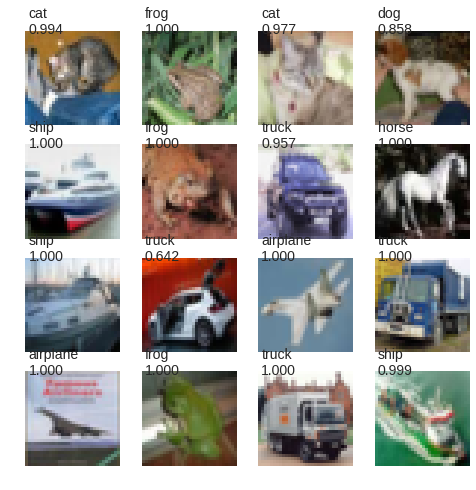

In [18]:
LABEL_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


cpu_model = model.sync_to_cpu()

from matplotlib import pyplot
%matplotlib inline

def plot_predictions(images, predictions):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  f, axes = pyplot.subplots(nc, 4)
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')
    
    label = LABEL_NAMES[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    axes[x, y].text(0.5, 0.5, label + '\n%.3f' % confidence, fontsize=14)

  pyplot.gcf().set_size_inches(8, 8)  

plot_predictions(np.squeeze(x_test[:16]), 
                 cpu_model.predict(x_test[:16]))